# EDA

## 年齢をDetectionするため、ある俳優の20歳と64歳と80歳の写真を用意した

### 20歳の頃

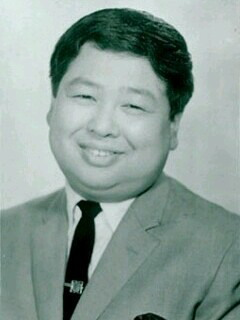

In [2]:
from IPython.display import Image
Image(filename='test_images/boo_young.jpg')

### 64歳の頃

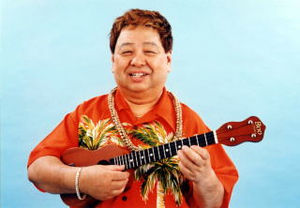

In [4]:
Image(filename='test_images/boo_64.jpeg')

### 80歳の頃

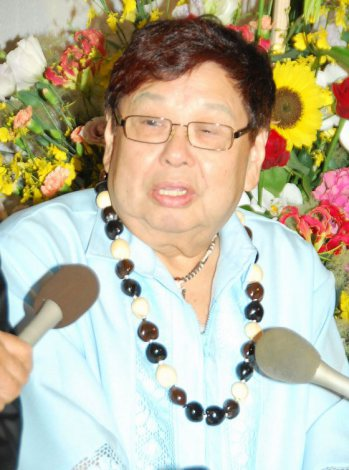

In [6]:
Image(filename='test_images/boo_80.jpg')

# ベンチマークモデル

## すでに公開＆実装されているOpenCVを用いたものがあるので、まずそれを実装する
https://github.com/yu4u/age-gender-estimation

## 使用シーン（動画をDetectionして、年齢とGenderを出す）、実際より５−１０歳ほど離れている（おっさんは若く、若い人はおっさんになった）

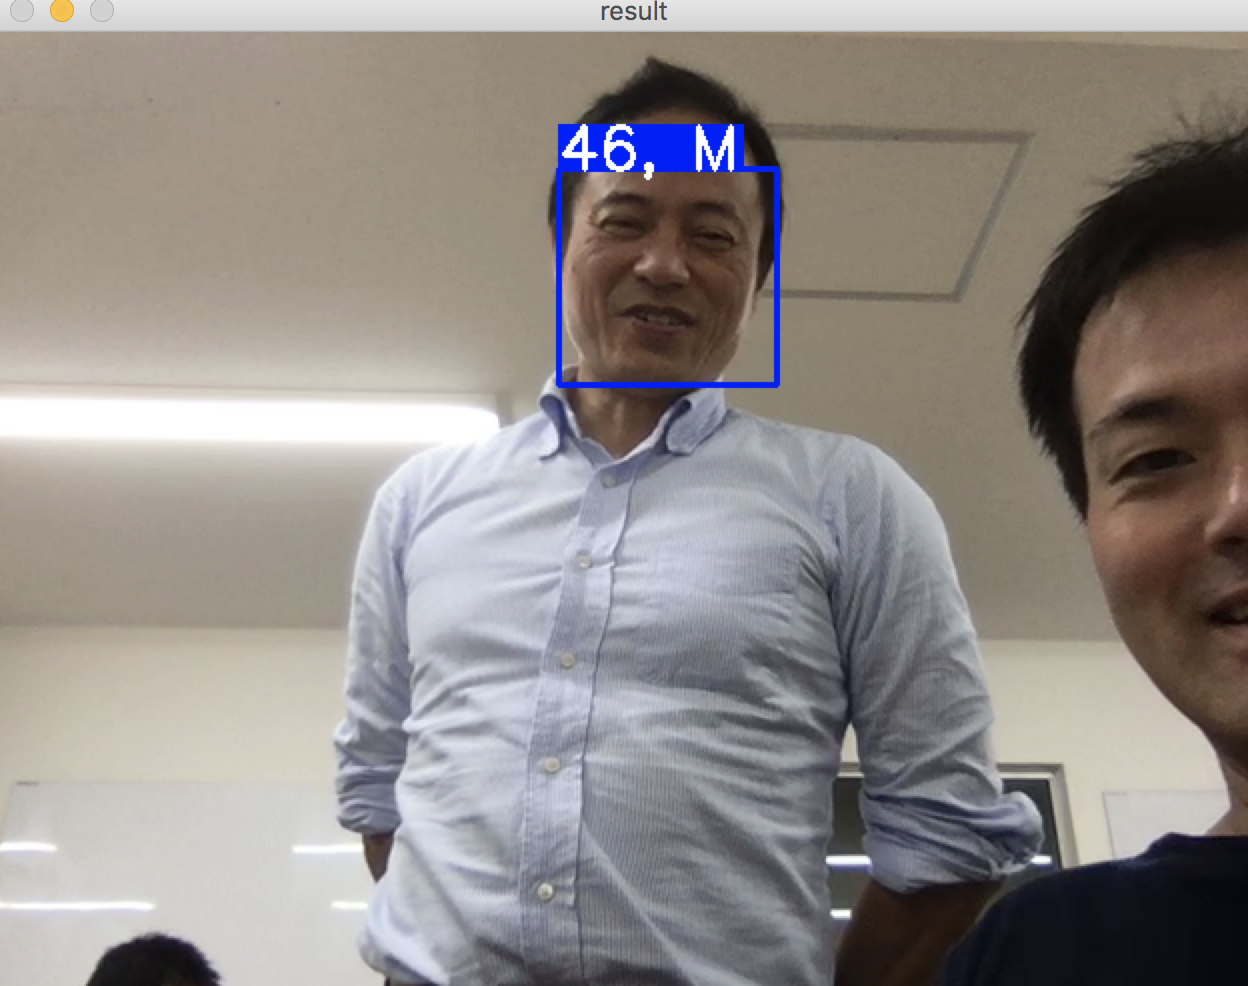

In [16]:
Image(filename='sample01.png')

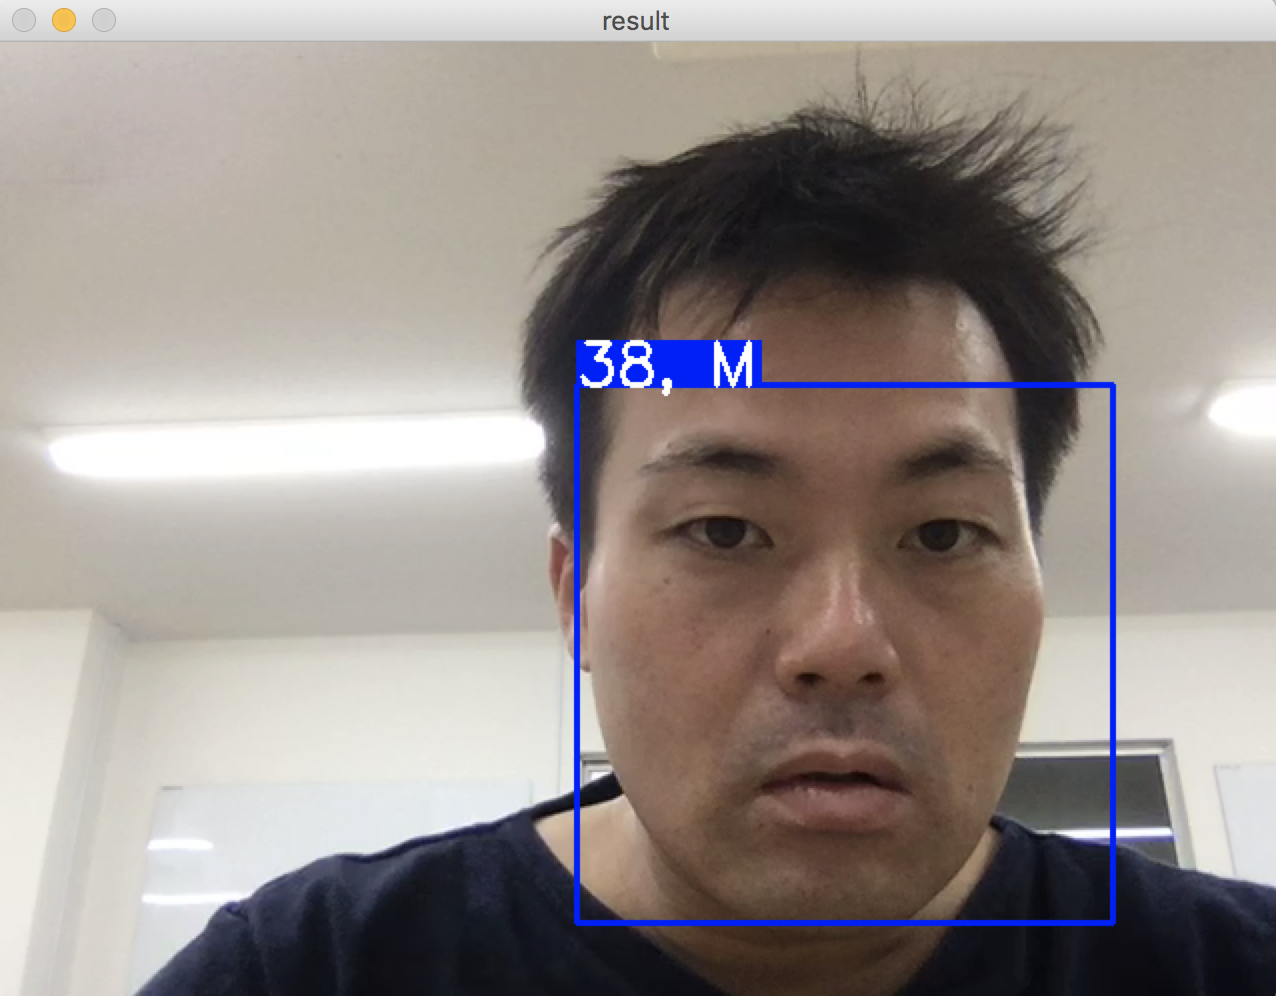

In [17]:
Image(filename='sample02.png')

## このモデルでは、顔のdetectionをしたあと、年齢を割り出している

In [2]:
###predict ages and genders of the detected faces
#             results = model.predict(faces)
#             predicted_genders = results[0]
#             ages = np.arange(0, 101).reshape(101, 1)
#             predicted_ages = results[1].dot(ages).flatten()

# 手作り年齢Detectionを実装する

1. 以下から重みをダウンロードしてdetection.pyと同じディレクトリ上に置く
  - 転移学習済みXception(年齢推定用)
  - https://www.dropbox.com/s/5s9tkbgqr557vmc/transfer_Xception_29.h5?dl=0
  - 学習済みweight(顔検出用)
  - https://www.dropbox.com/s/cjjolgk5h0rc1bk/weights.05-3.15.hdf5?dl=0


2. S3のbucket nameをs3側で登録し、BOTO3の部分でアップデートする
　- 今回は、Dic Engineering Projectという名前（あとは.aws/credentialを使うのでaws CLIを使えるようにしておく）

## 実行ファイルの構造

以下のようになっているので、ローカルでpython predict.pyを実行すると、ローカルでのURLが開く

- predict.py: predictのPythonコードで以下のコードを実行し、flaskでウェブページを生成する。
    - model.py: 学習モデルの定義（年齢、顔のDetection）
    - ssd.py: 顔のDetectionのためのアルゴリズム

## 今回のModel 

- 以前に作成したSSDで顔のDetectionを行う（SSDはそもそもKerasのバージョンが低い際に作成されていたので、修正が必要）
- load_modelですでに学習済みの重みを活用する

In [1]:
import numpy as np
import cv2
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Model
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import load_model
from ssd import SSD300
from ssd_utils import BBoxUtility

Using TensorFlow backend.


In [2]:
#顔検出モデルと年齢・性別検出モデルを復元
age_detector = load_model("transfer_Xception_29.h5")
NUM_CLASSES = 2
input_shape = (300, 300, 3)
priors = pickle.load(open('prior_boxes_ssd300.pkl', 'rb'))
bbox_util = BBoxUtility(NUM_CLASSES, priors)
face_detector = SSD300(input_shape, num_classes=NUM_CLASSES)
face_detector.load_weights('weights.05-3.15.hdf5', by_name=True)

/Users/szkhome/diveintocode-term0/Age_Detector/ssd.py:41: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="conv1_1", padding="same")`
  name='conv1_1')(net['input'])
/Users/szkhome/diveintocode-term0/Age_Detector/ssd.py:45: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="conv1_2", padding="same")`
  name='conv1_2')(net['conv1_1'])
/Users/szkhome/diveintocode-term0/Age_Detector/ssd.py:47: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D((2, 2), strides=(2, 2), name="pool1", padding="same")`
  name='pool1')(net['conv1_2'])
/Users/szkhome/diveintocode-term0/Age_Detector/ssd.py:52: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="conv2_1", padding="same")`
  name='conv2_1')(net['pool1'])
/Users/szkhome/diveintocode-term0/Age_Detector/ssd.py:56: UserWarning: Update your `Conv2D` call to the Keras 

### 年齢のDetection

In [3]:
def age_detect(self, input):
    #先頭にNUMの次元が必要なので追加
    input_add = input
    age_predict = age_detector.predict(input_add)
    # 年齢をsigmoidの出力（０〜１）から元に戻す（１を１１６歳にしている）
    age = np.round(age_predict[0]*116).astype(int)
    # 性別
    gender = np.zeros([age_predict[1].shape[0],1],dtype=str)
    for i in range(age_predict[1].shape[0]):
        # 性別は[0.2,0.8]ならF , [0.6,0.4]ならM のように判定
        if 0.5 <= age_predict[1][i][0]:
            gender[i] = 'M'
        else:
            gender[i] = 'F'

    return age, gender #リターンをarray形式で統一

### 顔のDetection

In [4]:
def face_detect(self, img_path, display=False):

    inputs, images, resize_imgs, bb_coordinate = [], [], [], []

    img = image.load_img(img_path, target_size=(300, 300))
    img = image.img_to_array(img)

    if '/' in img_path:
        img_original = image.load_img(img_path)
        img_original = image.img_to_array(img_original)
    else:
        # s3から取得した場合
        img_original = np.array(image.load_img(img_path))


    images.append(img_original)
    inputs.append(img)
    inputs = preprocess_input(np.array(inputs))

    # predict
    preds = self.face_detector.predict(inputs, batch_size=1, verbose=0)
    results = self.bbox_util.detection_out(preds)

    for i, img in enumerate(images):
        # Parse the outputs.
        det_label = results[i][:, 0]
        det_conf = results[i][:, 1]
        det_xmin = results[i][:, 2]
        det_ymin = results[i][:, 3]
        det_xmax = results[i][:, 4]
        det_ymax = results[i][:, 5]

        top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.3]

        top_conf = det_conf[top_indices]
        top_label_indices = det_label[top_indices].tolist()
        top_xmin = det_xmin[top_indices]
        top_ymin = det_ymin[top_indices]
        top_xmax = det_xmax[top_indices]
        top_ymax = det_ymax[top_indices]

        for i in range(top_conf.shape[0]):
            xmin = int(round(top_xmin[i] * img.shape[1]))
            ymin = int(round(top_ymin[i] * img.shape[0]))
            xmax = int(round(top_xmax[i] * img.shape[1]))
            ymax = int(round(top_ymax[i] * img.shape[0]))
            score = top_conf[i]
            label = int(top_label_indices[i])

            bb_coordinate.append(np.array([xmin, ymin, xmax, ymax]))
            detect_img = img_original[ymin:ymax, xmin: xmax, :]
            detect_img = cv2.resize(detect_img,(200, 200))
            resize_imgs.append(detect_img)

    # リサイズ画像の配列と元画像の位置左上の(x,y), 右下の(x,y)を返す
    return np.array(resize_imgs), np.array(bb_coordinate), img_original

## Detectionするための写真の入力や出力を定義する

In [10]:
import json
import numpy as np
import os
import model
import boto3
import cv2
from PIL import Image
from io import BytesIO
from datetime import datetime
from flask import Flask, render_template, request, redirect, url_for
from werkzeug import secure_filename
from keras.preprocessing import image


### 自身の名称を app という名前でインスタンス化する

In [11]:
# 自身の名称を app という名前でインスタンス化する
app = Flask(__name__)
app.config['DEBUG'] = True
# 投稿画像の保存先
UPLOAD_FOLDER = './static/images'

root=1

### 投稿の関数を定義する

In [14]:
def post():
  if request.method == 'POST':
      if not request.files['file'].filename == u'':
          # アップロードされたファイルをローカルフォルダに保存
          f = request.files['file']
          if root == 2:
              img_path = os.path.join(UPLOAD_FOLDER, secure_filename(f.filename))
              f.save(img_path)

          else:
              # ローカルフォルダに保存したファイルをS3に保存
              bucket_name = "dicengineeringprj1"
              s3 = boto3.resource('s3')
              s3c = boto3.client('s3')
              s3c.upload_fileobj(f, bucket_name, 'upload/'+ f.filename)
              bucket = s3.Bucket(bucket_name)
              object = bucket.Object('upload/' + f.filename)
              img_path = BytesIO(object.get()['Body'].read())

          # model.pyへアップロードされた画像を渡す
          Detect_instance = model.Detectors()
          face_img, coordinate, original = Detect_instance.face_detect(img_path)
          age, gender = Detect_instance.age_detect(face_img/255.0)

          if root == 1:
              for i in range(coordinate.shape[0]):
                  # 顔部分を枠で囲む
                  cv2.rectangle(original, tuple(coordinate[i][0:2]),\
                                tuple(coordinate[i][2:4]),\
                                (0, 122, 200), thickness=2)
                  cv2.putText(original, str(age[i][0]), (coordinate[i][0]+20,coordinate[i][1]+20), \
                              cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 255, 0), 4,lineType=8)
              # 顔部分を赤線で囲った画像の保存先
              now_time = datetime.now().strftime("%Y%m%d%H%M%S")
              detected_img_path = './static/images/' + 'detected_'+ now_time +f.filename
              # 顔部分を赤線で囲った画像の保存
              pil_img = Image.fromarray(original)
              pil_img.save(detected_img_path)

              result = [1, detected_img_path, face_img.shape, coordinate.shape]
          else:
              # JSON 作成
              persons = dict()
              for i in range(age[0].shape[0]):
                  contents = dict()
                  coordi = dict()
                  coordi["x1"]=int(coordinate[i][0])
                  coordi["y1"]=int(coordinate[i][1])
                  coordi["x2"]=int(coordinate[i][2])
                  coordi["y2"]=int(coordinate[i][3])
                  contents["age"] = int(age[i][0])
                  contents["coordinate"] = coordi
                  persons["person"+str(i)] = contents

              persons["image"] = f.filename
              result =[2, json.dumps(persons)]

      else:
          result = []

      return render_template('index.html', result=result)
  else:
      # エラーなどでリダイレクトしたい場合
      return redirect(url_for('index'))

# 前準備

## S3にDic Engineering Projectで保存できるようにする

In [17]:
# ローカルフォルダに保存したファイルをS3に保存

# f = request.files['file']

# bucket_name = "dicengineeringprj1"
# s3 = boto3.resource('s3')
# s3c = boto3.client('s3')
# s3c.upload_fileobj(f, bucket_name, 'upload/'+ f.filename)
# bucket = s3.Bucket(bucket_name)
# object = bucket.Object('upload/' + f.filename)
# img_path = BytesIO(object.get()['Body'].read())

## SSD300（論文丸パクリを、kerasの2018年版にアップデート（mergeが引退している）

In [19]:
"""Keras implementation of SSD."""

import keras.backend as K
from keras.layers import Activation
from keras.layers import AtrousConvolution2D
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import GlobalAveragePooling2D
from keras.layers import Input
from keras.layers import MaxPooling2D
#from keras.layers import merge
from keras.layers import Concatenate
from keras.layers import Reshape
from keras.layers import ZeroPadding2D
from keras.models import Model

from ssd_layers import Normalize
from ssd_layers import PriorBox


def SSD300(input_shape, num_classes=21):
    """SSD300 architecture.

    # Arguments
        input_shape: Shape of the input image,
            expected to be either (300, 300, 3) or (3, 300, 300)(not tested).
        num_classes: Number of classes including background.

    # References
        https://arxiv.org/abs/1512.02325
    """
    net = {}
    # Block 1
    input_tensor = input_tensor = Input(shape=input_shape)
    img_size = (input_shape[1], input_shape[0])
    net['input'] = input_tensor
    net['conv1_1'] = Conv2D(64, (3, 3),
                                   activation='relu',
                                   border_mode='same',
                                   name='conv1_1')(net['input'])
    net['conv1_2'] = Conv2D(64, (3, 3),
                                   activation='relu',
                                   border_mode='same',
                                   name='conv1_2')(net['conv1_1'])
    net['pool1'] = MaxPooling2D((2, 2), strides=(2, 2), border_mode='same',
                                name='pool1')(net['conv1_2'])
    # Block 2
    net['conv2_1'] = Conv2D(128, (3, 3),
                                   activation='relu',
                                   border_mode='same',
                                   name='conv2_1')(net['pool1'])
    net['conv2_2'] = Conv2D(128, (3, 3),
                                   activation='relu',
                                   border_mode='same',
                                   name='conv2_2')(net['conv2_1'])
    net['pool2'] = MaxPooling2D((2, 2), strides=(2, 2), border_mode='same',
                                name='pool2')(net['conv2_2'])
    # Block 3
    net['conv3_1'] = Conv2D(256, (3, 3),
                                   activation='relu',
                                   border_mode='same',
                                   name='conv3_1')(net['pool2'])
    net['conv3_2'] = Conv2D(256, (3, 3),
                                   activation='relu',
                                   border_mode='same',
                                   name='conv3_2')(net['conv3_1'])
    net['conv3_3'] = Conv2D(256, (3, 3),
                                   activation='relu',
                                   border_mode='same',
                                   name='conv3_3')(net['conv3_2'])
    net['pool3'] = MaxPooling2D((2, 2), strides=(2, 2), border_mode='same',
                                name='pool3')(net['conv3_3'])
    # Block 4
    net['conv4_1'] = Conv2D(512, (3, 3),
                                   activation='relu',
                                   border_mode='same',
                                   name='conv4_1')(net['pool3'])
    net['conv4_2'] = Conv2D(512, (3, 3),
                                   activation='relu',
                                   border_mode='same',
                                   name='conv4_2')(net['conv4_1'])
    net['conv4_3'] = Conv2D(512, (3, 3),
                                   activation='relu',
                                   border_mode='same',
                                   name='conv4_3')(net['conv4_2'])
    net['pool4'] = MaxPooling2D((2, 2), strides=(2, 2), border_mode='same',
                                name='pool4')(net['conv4_3'])
    # Block 5
    net['conv5_1'] = Conv2D(512, (3, 3),
                                   activation='relu',
                                   border_mode='same',
                                   name='conv5_1')(net['pool4'])
    net['conv5_2'] = Conv2D(512, (3, 3),
                                   activation='relu',
                                   border_mode='same',
                                   name='conv5_2')(net['conv5_1'])
    net['conv5_3'] = Conv2D(512, (3, 3),
                                   activation='relu',
                                   border_mode='same',
                                   name='conv5_3')(net['conv5_2'])
    net['pool5'] = MaxPooling2D((3, 3), strides=(1, 1), border_mode='same',
                                name='pool5')(net['conv5_3'])
    # FC6
    net['fc6'] = AtrousConvolution2D(1024, 3, 3, atrous_rate=(6, 6),
                                     activation='relu', border_mode='same',
                                     name='fc6')(net['pool5'])
    # x = Dropout(0.5, name='drop6')(x)
    # FC7
    net['fc7'] = Conv2D(1024, (1, 1), activation='relu',
                               border_mode='same', name='fc7')(net['fc6'])
    # x = Dropout(0.5, name='drop7')(x)
    # Block 6
    net['conv6_1'] = Conv2D(256, (1, 1), activation='relu',
                                   border_mode='same',
                                   name='conv6_1')(net['fc7'])
    net['conv6_2'] = Conv2D(512, (3, 3), subsample=(2, 2),
                                   activation='relu', border_mode='same',
                                   name='conv6_2')(net['conv6_1'])
    # Block 7
    net['conv7_1'] = Conv2D(128, (1, 1), activation='relu',
                                   border_mode='same',
                                   name='conv7_1')(net['conv6_2'])
    net['conv7_2'] = ZeroPadding2D()(net['conv7_1'])
    net['conv7_2'] = Conv2D(256, (3, 3), subsample=(2, 2),
                                   activation='relu', border_mode='valid',
                                   name='conv7_2')(net['conv7_2'])
    # Block 8
    net['conv8_1'] = Conv2D(128, (1, 1), activation='relu',
                                   border_mode='same',
                                   name='conv8_1')(net['conv7_2'])
    net['conv8_2'] = Conv2D(256, (3, 3), subsample=(2, 2),
                                   activation='relu', border_mode='same',
                                   name='conv8_2')(net['conv8_1'])
    # Last Pool
    net['pool6'] = GlobalAveragePooling2D(name='pool6')(net['conv8_2'])
    # Prediction from conv4_3
    net['conv4_3_norm'] = Normalize(20, name='conv4_3_norm')(net['conv4_3'])
    num_priors = 3
    x = Conv2D(num_priors * 4, 3, 3, border_mode='same',
                      name='conv4_3_norm_mbox_loc')(net['conv4_3_norm'])
    net['conv4_3_norm_mbox_loc'] = x
    flatten = Flatten(name='conv4_3_norm_mbox_loc_flat')
    net['conv4_3_norm_mbox_loc_flat'] = flatten(net['conv4_3_norm_mbox_loc'])
    name = 'conv4_3_norm_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    x = Conv2D(num_priors * num_classes, 3, 3, border_mode='same',
                      name=name)(net['conv4_3_norm'])
    net['conv4_3_norm_mbox_conf'] = x
    flatten = Flatten(name='conv4_3_norm_mbox_conf_flat')
    net['conv4_3_norm_mbox_conf_flat'] = flatten(net['conv4_3_norm_mbox_conf'])
    priorbox = PriorBox(img_size, 30.0, aspect_ratios=[2],
                        variances=[0.1, 0.1, 0.2, 0.2],
                        name='conv4_3_norm_mbox_priorbox')
    net['conv4_3_norm_mbox_priorbox'] = priorbox(net['conv4_3_norm'])
    # Prediction from fc7
    num_priors = 6
    net['fc7_mbox_loc'] = Conv2D(num_priors * 4, 3, 3,
                                        border_mode='same',
                                        name='fc7_mbox_loc')(net['fc7'])
    flatten = Flatten(name='fc7_mbox_loc_flat')
    net['fc7_mbox_loc_flat'] = flatten(net['fc7_mbox_loc'])
    name = 'fc7_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    net['fc7_mbox_conf'] = Conv2D(num_priors * num_classes, 3, 3,
                                         border_mode='same',
                                         name=name)(net['fc7'])
    flatten = Flatten(name='fc7_mbox_conf_flat')
    net['fc7_mbox_conf_flat'] = flatten(net['fc7_mbox_conf'])
    priorbox = PriorBox(img_size, 60.0, max_size=114.0, aspect_ratios=[2, 3],
                        variances=[0.1, 0.1, 0.2, 0.2],
                        name='fc7_mbox_priorbox')
    net['fc7_mbox_priorbox'] = priorbox(net['fc7'])
    # Prediction from conv6_2
    num_priors = 6
    x = Conv2D(num_priors * 4, 3, 3, border_mode='same',
                      name='conv6_2_mbox_loc')(net['conv6_2'])
    net['conv6_2_mbox_loc'] = x
    flatten = Flatten(name='conv6_2_mbox_loc_flat')
    net['conv6_2_mbox_loc_flat'] = flatten(net['conv6_2_mbox_loc'])
    name = 'conv6_2_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    x = Conv2D(num_priors * num_classes, 3, 3, border_mode='same',
                      name=name)(net['conv6_2'])
    net['conv6_2_mbox_conf'] = x
    flatten = Flatten(name='conv6_2_mbox_conf_flat')
    net['conv6_2_mbox_conf_flat'] = flatten(net['conv6_2_mbox_conf'])
    priorbox = PriorBox(img_size, 114.0, max_size=168.0, aspect_ratios=[2, 3],
                        variances=[0.1, 0.1, 0.2, 0.2],
                        name='conv6_2_mbox_priorbox')
    net['conv6_2_mbox_priorbox'] = priorbox(net['conv6_2'])
    # Prediction from conv7_2
    num_priors = 6
    x = Conv2D(num_priors * 4, 3, 3, border_mode='same',
                      name='conv7_2_mbox_loc')(net['conv7_2'])
    net['conv7_2_mbox_loc'] = x
    flatten = Flatten(name='conv7_2_mbox_loc_flat')
    net['conv7_2_mbox_loc_flat'] = flatten(net['conv7_2_mbox_loc'])
    name = 'conv7_2_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    x = Conv2D(num_priors * num_classes, 3, 3, border_mode='same',
                      name=name)(net['conv7_2'])
    net['conv7_2_mbox_conf'] = x
    flatten = Flatten(name='conv7_2_mbox_conf_flat')
    net['conv7_2_mbox_conf_flat'] = flatten(net['conv7_2_mbox_conf'])
    priorbox = PriorBox(img_size, 168.0, max_size=222.0, aspect_ratios=[2, 3],
                        variances=[0.1, 0.1, 0.2, 0.2],
                        name='conv7_2_mbox_priorbox')
    net['conv7_2_mbox_priorbox'] = priorbox(net['conv7_2'])
    # Prediction from conv8_2
    num_priors = 6
    x = Conv2D(num_priors * 4, 3, 3, border_mode='same',
                      name='conv8_2_mbox_loc')(net['conv8_2'])
    net['conv8_2_mbox_loc'] = x
    flatten = Flatten(name='conv8_2_mbox_loc_flat')
    net['conv8_2_mbox_loc_flat'] = flatten(net['conv8_2_mbox_loc'])
    name = 'conv8_2_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    x = Conv2D(num_priors * num_classes, 3, 3, border_mode='same',
                      name=name)(net['conv8_2'])
    net['conv8_2_mbox_conf'] = x
    flatten = Flatten(name='conv8_2_mbox_conf_flat')
    net['conv8_2_mbox_conf_flat'] = flatten(net['conv8_2_mbox_conf'])
    priorbox = PriorBox(img_size, 222.0, max_size=276.0, aspect_ratios=[2, 3],
                        variances=[0.1, 0.1, 0.2, 0.2],
                        name='conv8_2_mbox_priorbox')
    net['conv8_2_mbox_priorbox'] = priorbox(net['conv8_2'])
    # Prediction from pool6
    num_priors = 6
    x = Dense(num_priors * 4, name='pool6_mbox_loc_flat')(net['pool6'])
    net['pool6_mbox_loc_flat'] = x
    name = 'pool6_mbox_conf_flat'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    x = Dense(num_priors * num_classes, name=name)(net['pool6'])
    net['pool6_mbox_conf_flat'] = x
    priorbox = PriorBox(img_size, 276.0, max_size=330.0, aspect_ratios=[2, 3],
                        variances=[0.1, 0.1, 0.2, 0.2],
                        name='pool6_mbox_priorbox')
    if K.image_dim_ordering() == 'tf':
        target_shape = (1, 1, 256)
    else:
        target_shape = (256, 1, 1)
    net['pool6_reshaped'] = Reshape(target_shape,
                                    name='pool6_reshaped')(net['pool6'])
    net['pool6_mbox_priorbox'] = priorbox(net['pool6_reshaped'])
    # Gather all predictions

    net['mbox_loc'] = Concatenate(axis=1)([net['conv4_3_norm_mbox_loc_flat'],
                             net['fc7_mbox_loc_flat'],
                             net['conv6_2_mbox_loc_flat'],
                             net['conv7_2_mbox_loc_flat'],
                             net['conv8_2_mbox_loc_flat'],
                             net['pool6_mbox_loc_flat']])

    net['mbox_conf'] = Concatenate(axis=1)([net['conv4_3_norm_mbox_conf_flat'],
                              net['fc7_mbox_conf_flat'],
                              net['conv6_2_mbox_conf_flat'],
                              net['conv7_2_mbox_conf_flat'],
                              net['conv8_2_mbox_conf_flat'],
                              net['pool6_mbox_conf_flat']])

    net['mbox_priorbox'] = Concatenate(axis=1)([net['conv4_3_norm_mbox_priorbox'],
                                  net['fc7_mbox_priorbox'],
                                  net['conv6_2_mbox_priorbox'],
                                  net['conv7_2_mbox_priorbox'],
                                  net['conv8_2_mbox_priorbox'],
                                  net['pool6_mbox_priorbox']])

    if hasattr(net['mbox_loc'], '_keras_shape'):
        num_boxes = net['mbox_loc']._keras_shape[-1] // 4
    elif hasattr(net['mbox_loc'], 'int_shape'):
        num_boxes = K.int_shape(net['mbox_loc'])[-1] // 4
    net['mbox_loc'] = Reshape((num_boxes, 4),
                              name='mbox_loc_final')(net['mbox_loc'])
    net['mbox_conf'] = Reshape((num_boxes, num_classes),
                               name='mbox_conf_logits')(net['mbox_conf'])
    net['mbox_conf'] = Activation('softmax',
                                  name='mbox_conf_final')(net['mbox_conf'])


    net['predictions'] = Concatenate(axis=2)([net['mbox_loc'],
                               net['mbox_conf'],
                               net['mbox_priorbox']])

    model = Model(net['input'], net['predictions'])
    return model
